# Continuity equation comparison between ours and Jing et al. (2022)
In this notebook, we compare our proximal algortihm and the algorithm by Jing et al. In particular, we will compare the violation of the continuity equation. It has been observe that the algorithm by Jing et al. sometimes outputs a solution with lower energy than our algorithm. Our hypothesis is that it is because their solution is not a feasible one i.e. it does not satisfy the continuity equation well. We will verify if this is true.

**Reference.**
Jing, Y., Chen, J., Li, L., & Lu, J. (2022). A deep learning framework for geodesics under spherical Wasserstein-Fisher-Rao metric and its application for weighted sample generation. arXiv. https://arxiv.org/abs/2208.12145

In [3]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
import matlab.engine
import io

# Set up

Here, we will create the densities we will use for the transport. We consider the domain $[-7,7]$ and the following two densities:

$\rho_0(x) = \frac{1}{3} N(x|-3, 1) + \frac{2}{3}N(x, 3, 1)$


$\rho_1(x) = N(x|0, 1)$

where $N(x|\mu, \sigma^2)$ denotes the pdf of normal distribtuion of mean $\mu$ and variance $\sigma^2$.

This is the same setting as [this experiment](../total_mass/[PARTIAL]SHK_ours_vs_jing_gaussian.ipynb) where their algorithm seemed to perform better.

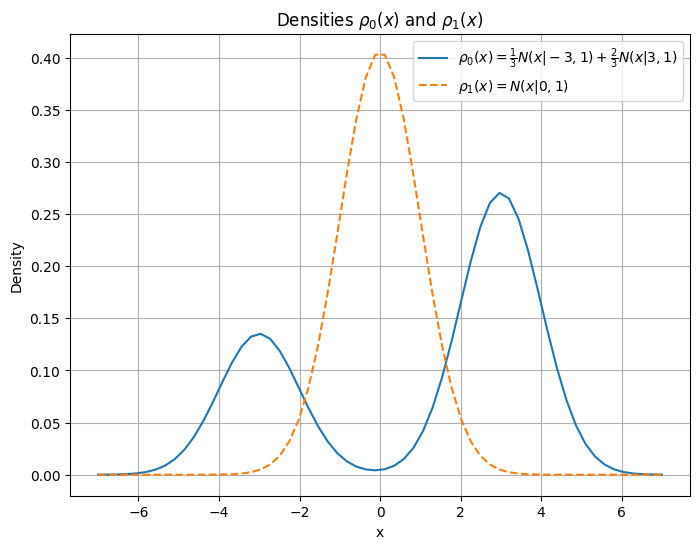

In [4]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Parameters
Nx = 60 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.007 # Originally 0.007
tao = 0.007 # Originally 0.007
N_itr = 10000  # Originally 1000000
X = [-7, 7] # Originally [-7, 7]
T = [0, 1]

dx = (X[1] - X[0]) / Nx
dt = 1 / Nt

x_space = np.linspace(X[0], X[1], Nx)
t_space = np.linspace(T[0], T[1], Nt)

# The initial density
# Compute densities
# Originally
#rho_0 = (1/3) * sp.stats.norm.pdf(x_space, loc=-3, scale=1) + (2/3) * sp.stats.norm.pdf(x_space, loc=3, scale=1)
#rho_1 = sp.stats.norm.pdf(x_space, loc=0, scale=1)
rho_0 = (1/3) * sp.stats.norm.pdf(x_space, loc=-3, scale=1) + (2/3) * sp.stats.norm.pdf(x_space, loc=3, scale=1)
rho_1 = sp.stats.norm.pdf(x_space, loc=0, scale=1)

rho_0 = rho_0 / (np.sum(rho_0) * dx) # Make sure they are prrobabiltiy densities
rho_1 = rho_1 / (np.sum(rho_1) * dx)

# Plot the densities
plt.figure(figsize=(8, 6))
plt.plot(x_space, rho_0, label=r"$\rho_0(x) = \frac{1}{3} N(x|-3, 1) + \frac{2}{3} N(x|3, 1)$")
plt.plot(x_space, rho_1, label=r"$\rho_1(x) = N(x|0, 1)$", linestyle='--')
plt.xlabel("x")
plt.ylabel("Density")
plt.title(r"Densities $\rho_0(x)$ and $\rho_1(x)$")
plt.legend()
plt.grid()
plt.show()

# Our algorithm

In [5]:
ll = (1.0, X[1]-X[0]) # size of time x space box
x_ours, lists = computeGeodesic(rho_0, rho_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


# Violation of continuity equation for our algorithm

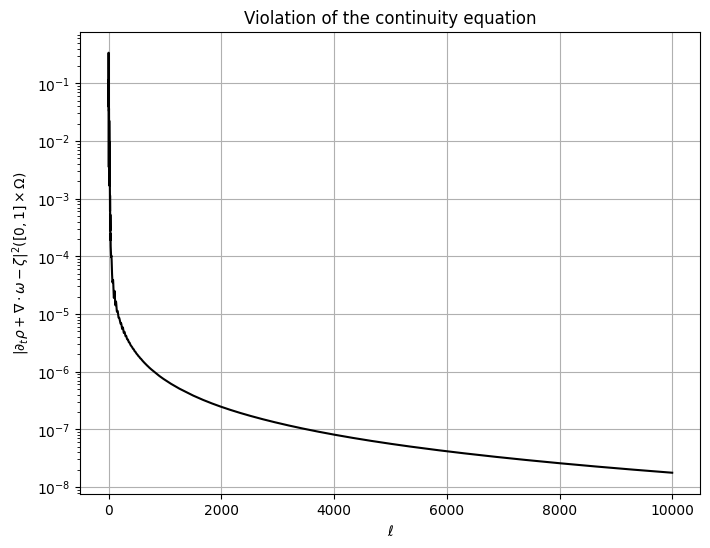

In [9]:
plt.figure(figsize=(8, 6))
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|^2([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Violation of the continuity equation")
plt.semilogy(lists[1], "k")
plt.grid()
plt.show()

# Jing et al. (2022)

In [11]:
# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

# Jing et al. (2022)
eng.workspace['Nx'] = float(Nx)
eng.workspace['Nt'] = float(Nt)
eng.workspace['alpha'] = float(alpha)
eng.workspace['mu'] = mu
eng.workspace['tao'] = tao
eng.workspace['N_itr'] = N_itr
eng.workspace['X'] = X
eng.workspace['T'] = T
eng.workspace['dx'] = dx
eng.workspace['dt'] = dt
eng.workspace['x_space'] = matlab.double(x_space.tolist())
eng.workspace['t_space'] = matlab.double(t_space.tolist())
eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
eng.WFR_main(nargout=0, stdout=output_buffer)

# Retrieving the results
rho_opt = np.array(eng.workspace['rho_opt'])
m = np.array(eng.workspace['m'])
ksi = np.array(eng.workspace['ksi'])

# Retrieving the results
Clist = np.array(eng.workspace['Clist'])

# Closing MATLAB engine
eng.quit()
print('✨ MATLAB Engine Closed... 🛠️')

✨ Starting MATLAB Engine... 🛠️
✨ MATLAB Engine Closed... 🛠️


# Plotting the result

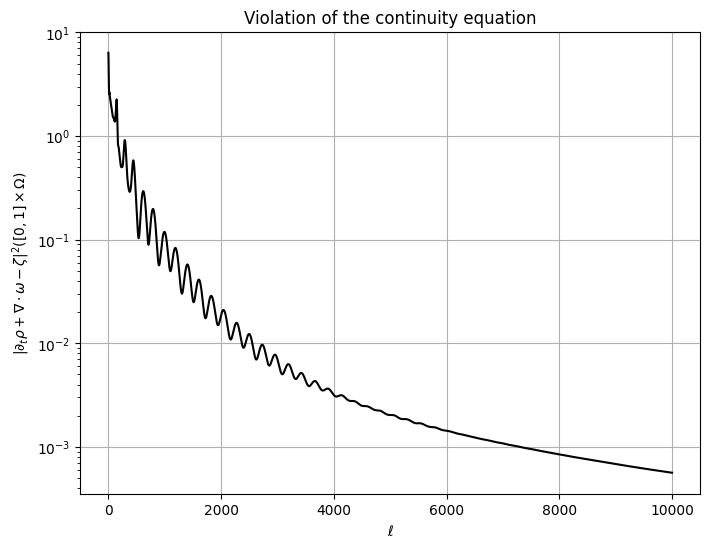

In [12]:
plt.figure(figsize=(8, 6))
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|^2([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Violation of the continuity equation")
plt.semilogy(Clist, "k")
plt.grid()
plt.show()